In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from art_clustering.data_loaders import WikiSubsetLoaderAgain

In [2]:
# Step 1: Extract Features
def extract_features(data_loader, model, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    all_features = []
    all_labels = []
    
    with torch.no_grad():  # No need to track gradients
        for images, labels in data_loader:  # You can ignore labels during clustering
            images = images.to(device)  # Send images to the device (GPU/CPU)
            features = model(images)  # Extract features from the model
            all_features.append(features.cpu().numpy())  # Store features in CPU
            all_labels.append(labels.cpu().numpy())  # Store true labels
    
    return np.concatenate(all_features, axis=0), np.concatenate(all_labels, axis=0)  # Combine all batches

In [ ]:
# Step 2: Perform Clustering (e.g., KMeans)
def perform_clustering(features, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    return kmeans.labels_  # Get the cluster labels

In [4]:
# Step 2: Perform Clustering (e.g., KMeans)
def perform_clustering(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    return kmeans.labels_  # Get the cluster labels

In [5]:
# Step 3: Visualize Clusters
def plot_clusters(features, cluster_labels, true_labels=None, method='PCA', n_components=2):
    """
    Visualizes the clusters in 2D using PCA or t-SNE.
    :param features: Feature vectors to be clustered
    :param cluster_labels: The labels assigned by the clustering algorithm (e.g., KMeans)
    :param true_labels: (optional) The true labels for comparison
    :param method: Dimensionality reduction method ('PCA' or 't-SNE')
    :param n_components: Number of components for reduction (2 for 2D plot)
    """
    # Dimensionality Reduction
    if method == 'PCA':
        pca = PCA(n_components=n_components)
        reduced_features = pca.fit_transform(features)
    elif method == 't-SNE':
        tsne = TSNE(n_components=n_components)
        reduced_features = tsne.fit_transform(features)
    else:
        raise ValueError("Method must be 'PCA' or 't-SNE'")

    plt.figure(figsize=(10, 8))

    # Plot clusters
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)

    if true_labels is not None:
        # Plot true labels with a different color map
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=true_labels, cmap='coolwarm', marker='x', alpha=0.7)

    # Add color bars
    plt.colorbar(scatter, label="Cluster Labels")
    if true_labels is not None:
        plt.colorbar(scatter, label="True Labels", alpha=0.7)

    plt.title(f'Clusters vs True Labels using {method}', fontsize=16)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

In [6]:
# Main Code to Run the Process
device = 'mps' if torch.cuda.is_available() else 'cpu'  # Set device

# Define the pre-trained model (e.g., ResNet50 for feature extraction)
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the final fully connected layer
model = model.to(device)

# Assuming you have the data loader and the model (feature extraction model) already
data_loader = WikiSubsetLoader(root_dir='/Volumes/T7/university/sem2/wikiart/smol_data').get_loader()

# Step 1: Extract Features
features, true_labels = extract_features(data_loader, model, device=device)

# Step 2: Perform Clustering (e.g., KMeans)
cluster_labels = perform_clustering(features, n_clusters=5)

# Step 3: Visualize the Clusters (using PCA or t-SNE)
plot_clusters(features, cluster_labels, true_labels=true_labels, method='PCA')  # or method='t-SNE'


/opt/anaconda3/envs/algo_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/algo_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/saska/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.2MB/s]


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm import tqdm
from torchvision.models import mobilenet_v2

from art_clustering.data_loaders import WikiSubsetLoaderAgain  # Make sure this path is correct

# --- 1. Set up device (MPS for Mac M3) ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Load data using your custom loader ---
data_loader = WikiSubsetLoaderAgain(
    root_dir='/Volumes/T7/university/sem2/wikiart/smol_data',
    batch_size=32,
    img_size=(224, 224),
    shuffle=True,
    normalize=False,
    max_per_class=2000  # 👈 NEW: limit to 2000 images per category
).get_loader()

# --- 3. Load MobileNetV2 ---
model = mobilenet_v2(pretrained=True).features
model.eval().to(device)

# --- 4. Extract features ---
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(data_loader, desc="Extracting features"):
        images = images.to(device)
        outputs = model(images)  # shape: (B, 1280, 7, 7)
        pooled = outputs.mean([2, 3])  # Global average pooling -> (B, 1280)
        all_features.append(pooled.cpu().numpy())
        all_labels.append(labels.numpy())

features = np.concatenate(all_features)
true_labels = np.concatenate(all_labels)
print(f"Feature shape: {features.shape}")

# --- 5. Dimensionality reduction (PCA to 50D, then to 2D for plotting) ---
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(features)

pca_2d = PCA(n_components=2)
vis_features = pca_2d.fit_transform(reduced_features)

# --- 6. Clustering with KMeans ---
n_clusters = len(data_loader.dataset.dataset.classes)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features)

# --- 7. Visualization ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(vis_features[:, 0], vis_features[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("KMeans Cluster Assignments")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.scatter(vis_features[:, 0], vis_features[:, 1], c=true_labels, cmap='tab10', s=10)
plt.title("Ground Truth Labels")
plt.axis('off')

plt.tight_layout()
plt.show()


Using device: mps


/opt/anaconda3/envs/algo_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/algo_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████| 250/250 [04:31<00:00,  1.09s/it]


Feature shape: (8000, 1280)


AttributeError: 'Subset' object has no attribute 'classes'

In [2]:
# --- 6. Clustering with KMeans ---
n_clusters = len(data_loader.dataset.dataset.classes)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features)

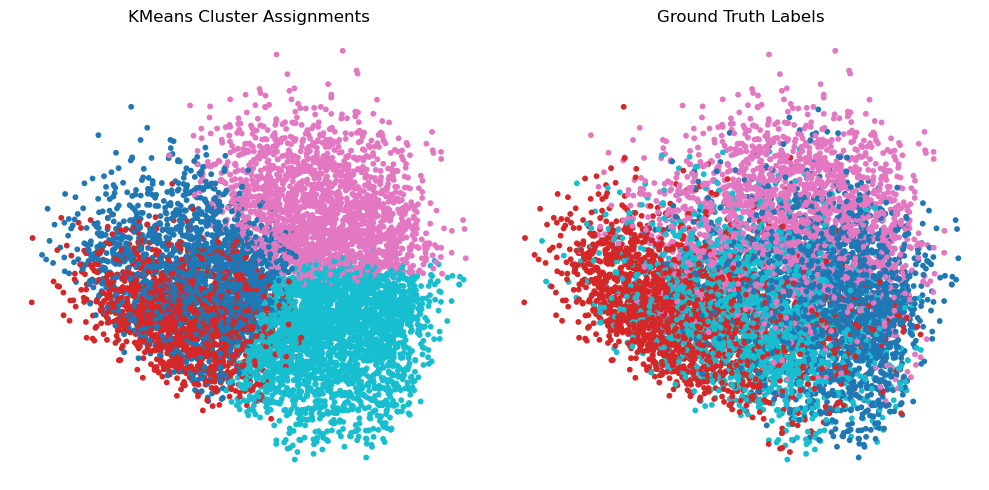

In [3]:
# --- 7. Visualization ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(vis_features[:, 0], vis_features[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("KMeans Cluster Assignments")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.scatter(vis_features[:, 0], vis_features[:, 1], c=true_labels, cmap='tab10', s=10)
plt.title("Ground Truth Labels")
plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
from collections import Counter

cluster_counts = Counter(cluster_labels)

# Print sorted cluster sizes
for cluster_id in sorted(cluster_counts):
    print(f"Cluster {cluster_id}: {cluster_counts[cluster_id]} images")


Cluster 0: 1871 images
Cluster 1: 1411 images
Cluster 2: 2041 images
Cluster 3: 2677 images
